# Time series forecasting Bitcoin Price üí∞üìà

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Download the data
The data is downloaded from [finance](https://finance.yahoo.com/quote/BTC-USD/history/) and preprocessed to keep only closing prices and dates.

In [3]:
!wget https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/data/bitcoin_prices.csv

--2023-09-21 05:34:02--  https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/data/bitcoin_prices.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82392 (80K) [text/plain]
Saving to: ‚Äòbitcoin_prices.csv‚Äô

bitcoin_prices.csv  100%[===================>]  80.46K  --.-KB/s    in 0.002s  

2023-09-21 05:34:02 (31.9 MB/s) - ‚Äòbitcoin_prices.csv‚Äô saved [82392/82392]



In [4]:
# let's read in Bitcoin data and parse the data
df = pd.read_csv("/content/bitcoin_prices.csv",
                  parse_dates=['Date'],
                 index_col=['Date']) #parse the date column and tell pandas column 1 is a datetime
df.head(3)

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483

In [5]:
df.tail(3)

Price
Date                    
2023-09-06  25753.236328
2023-09-07  26240.195313
2023-09-08  26233.162109

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3630 entries, 2013-10-01 to 2023-09-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3630 non-null   float64
dtypes: float64(1)
memory usage: 56.7 KB


In [9]:
len(df)

3630

In [10]:
bitcoin_prices = df

We've collected the historical price of Bitcoin for the past ~8years but there's 3279 samples.


Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> **üîëNote**: The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

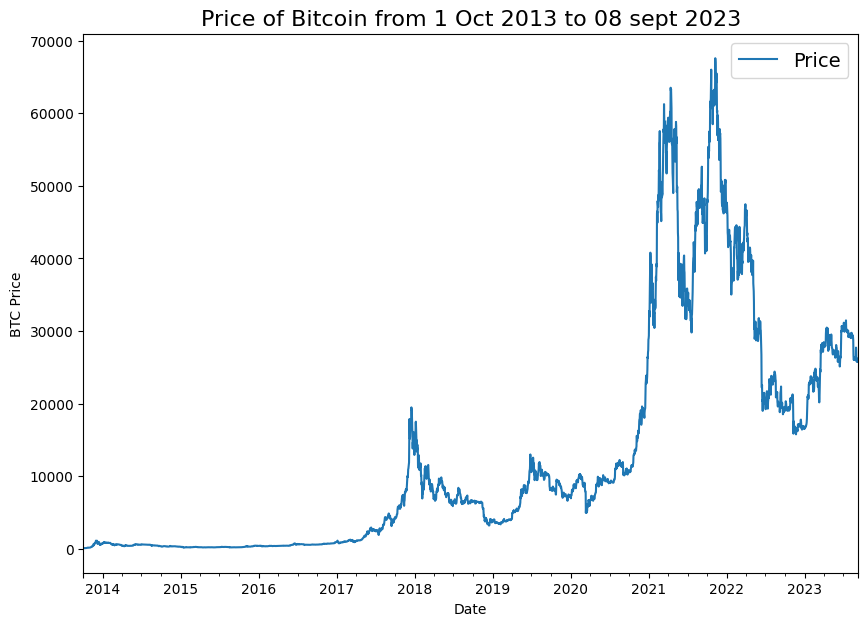

In [12]:
bitcoin_prices.plot(figsize=(10,7))
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 08 sept 2023", fontsize=16)
plt.legend(fontsize=14);

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
 * Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

## Create train and test sets with time series data

In [13]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [20]:
# Normalize the prices
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
norm_price = prices.reshape(-1, 1)
norm_price = scaler.fit_transform(norm_price)
norm_price[:10], prices[:10]

(array([[0.0002234 ],
        [0.00025008],
        [0.        ],
        [0.00014957],
        [0.00018906],
        [0.00017893],
        [0.00019583],
        [0.00021418],
        [0.00022924],
        [0.00025759]]),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [21]:
# Splitting the data into train and test split
split_size = int(0.8 * len(norm_price)) #80%train 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], norm_price[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], norm_price[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2904, 2904, 726, 726)

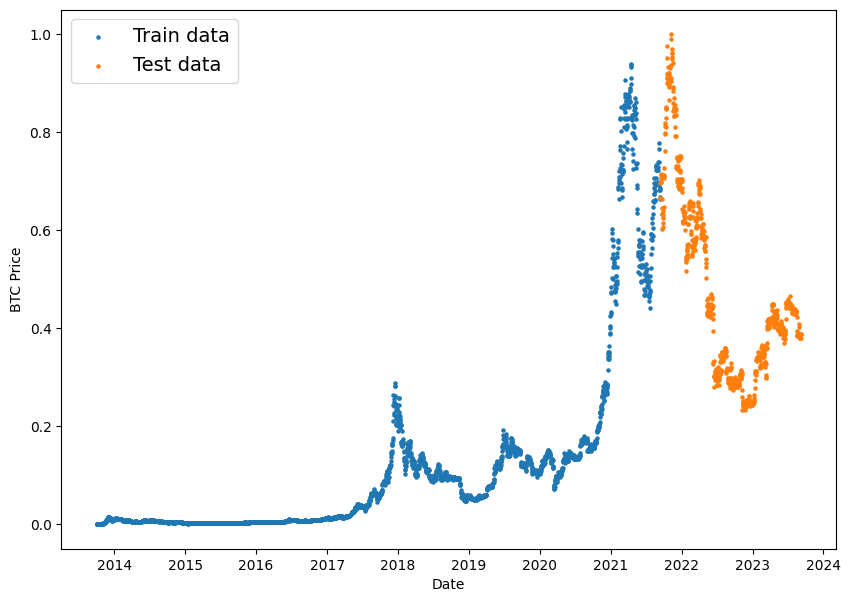

In [22]:
# plot train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Creating plotting function

In [23]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting a value index from start of timesteps)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # PLot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) #make label bigger
  plt.grid(True)

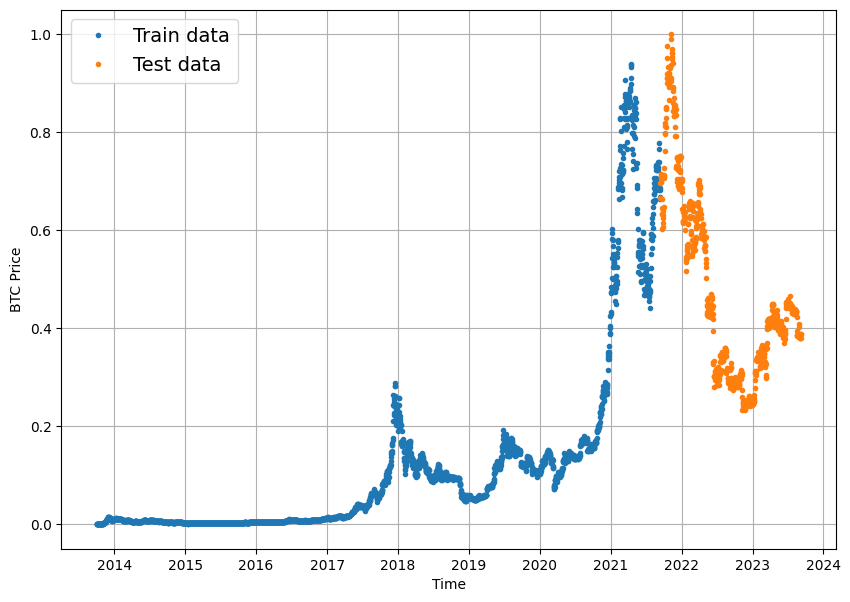

In [24]:
# Test plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")


## Format Data : Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to  make the prediction

In [26]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

To speed things up, we'll leverage `tf.timeseries_dataset_from_array
`

Our function will do below:

```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7 ,8]]
```


In [39]:
def make_windows_horizon(x, horizon=HORIZON, window_size=WINDOW_SIZE):
  """
  Returns windows and horizons
  """
  labels = x[WINDOW_SIZE:]
  data= x[:]
  windowed_data = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                         targets=labels,
                                                         sequence_length=window_size)
     # Initialize empty lists to collect windows and labels
  windows = []
  all_labels = []

  for data in windowed_data:
        batch_windows, batch_labels = data
        windows.extend(batch_windows.numpy())
        all_labels.extend(batch_labels.numpy())

  # Convert lists to NumPy arrays
  windows = np.array(windows)
  all_labels = np.array(all_labels)

  return windows, all_labels

In [40]:
full_windows, full_labels = make_windows_horizon(tf.squeeze(norm_price))
len(full_windows), len(full_labels)

(3623, 3623)

In [36]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.0002234  0.00025008 0.         0.00014957 0.00018906 0.00017893
 0.00019583] -> Label: 0.0002141794581993052
Window: [0.00025008 0.         0.00014957 0.00018906 0.00017893 0.00019583
 0.00021418] -> Label: 0.0002292406271591455
Window: [0.         0.00014957 0.00018906 0.00017893 0.00019583 0.00021418
 0.00022924] -> Label: 0.00025758645869285407


## Turning windows into train and test sets

In [41]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels in train and test splits.
  """
  split_size = int((len(windows)) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [42]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2898, 725, 2898, 725)

In [43]:
# Modelling checkpoints
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name ),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model(window = 7, horizon=1)
* Normalized data
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs





In [45]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer="adam",
                metrics=["mae", "mse"])

# 3. fit the model
model_1.fit(x=train_windows, y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data= (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [46]:
# Evaluate model on test data
model_1.evaluate(test_windows,test_labels )

23/23 [==============================] - 0s 2ms/step - loss: 0.0114 - mae: 0.0114 - mse: 2.8238e-04


[0.011426548473536968, 0.011426548473536968, 0.0002823806134983897]

In [47]:
# load in saved best performance model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

23/23 [==============================] - 0s 2ms/step - loss: 0.0108 - mae: 0.0108 - mse: 2.7123e-04


[0.010764841921627522, 0.010764841921627522, 0.00027123340987600386]

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

we're predicting a number, so that means we have a form of regression problem.

Because we're working on a regrression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean absolute error
* MSE - Mean squared error
* RMSE - Root mean squared error
* MAPE/sMAPE - (symmetric) Mean absolute percentage error
* MASE -  Scaled Mean absolute error

For all the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts(y_pred) compare against the actual values (y_true or ground truth values)?**

In [50]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) #seasonality is 1 day.. hence shift of 1

  return mae / mae_naive_no_season

In [49]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype(for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred , dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae":mae.numpy(),
           "mape": mape.numpy(),
          "mase": mase.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
         }

In [81]:
def evaluate_preds_normalized(y_true, y_pred, scaler):
    """
    Calculate various evaluation metrics for regression predictions on normalized data
    and convert them to non-normalized metrics using a scaler.

    Args:
        y_true (tf.Tensor or np.ndarray): True target values.
        y_pred (tf.Tensor): Predicted target values.
        scaler: Scaler object (e.g., StandardScaler, MinMaxScaler) used for normalization.

    Returns:
        dict: A dictionary containing non-normalized evaluation metrics.
    """
    if y_true.ndim == 1:
      y_true = tf.expand_dims(y_true, axis=1)
    if y_pred.ndim == 1:
      y_pred = tf.expand_dims(y_pred, axis=1)

    # Convert normalized predictions to non-normalized values using the scaler
    y_true_non_normalized = scaler.inverse_transform(y_true)
    y_pred_non_normalized = scaler.inverse_transform(y_pred.numpy())

    # Calculate various evaluation metrics on non-normalized data
    mae_non_normalized = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true_non_normalized, y_pred_non_normalized))
    mse_non_normalized = tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true_non_normalized, y_pred_non_normalized))
    rmse_non_normalized = tf.reduce_mean(tf.sqrt(mse_non_normalized))
    mape_non_normalized = tf.reduce_mean(tf.keras.metrics.mean_absolute_percentage_error(y_true_non_normalized, y_pred_non_normalized))
    mase_non_normalized = mean_absolute_scaled_error(y_true_non_normalized, y_pred_non_normalized)

    return {
        "mae": mae_non_normalized.numpy(),
        "mape": mape_non_normalized.numpy(),
        "mase": mase_non_normalized.numpy(),
        "mse": mse_non_normalized.numpy(),
        "rmse": rmse_non_normalized.numpy(),
    }

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts because actual forecasts, they're only pseudo forecasts because are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [52]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #returns 1Darray of predictions

In [53]:
# Make Predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

23/23 [==============================] - 0s 2ms/step


(725,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.66367567, 0.68952817, 0.7101479 , 0.70565534, 0.70217896,
        0.7121529 , 0.6969701 , 0.6407682 , 0.6046978 , 0.6288132 ],
       dtype=float32)>)

In [84]:
# Evaluate preds
model_1_results_normalized = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results_normalized

{'mae': 0.010764842,
 'mape': 2.2445972,
 'mase': 1.0721372,
 'mse': 0.0002712334,
 'rmse': 0.016469166}

In [83]:
# Evaluate preds
model_1_results = evaluate_preds_normalized(y_true=test_labels,
                                                       y_pred=model_1_preds,
                                                       scaler=scaler)
model_1_results

{'mae': 726.1773,
 'mape': 2.2359478,
 'mase': 1.0721372334355557,
 'mse': 1234278.5,
 'rmse': 1110.9808}

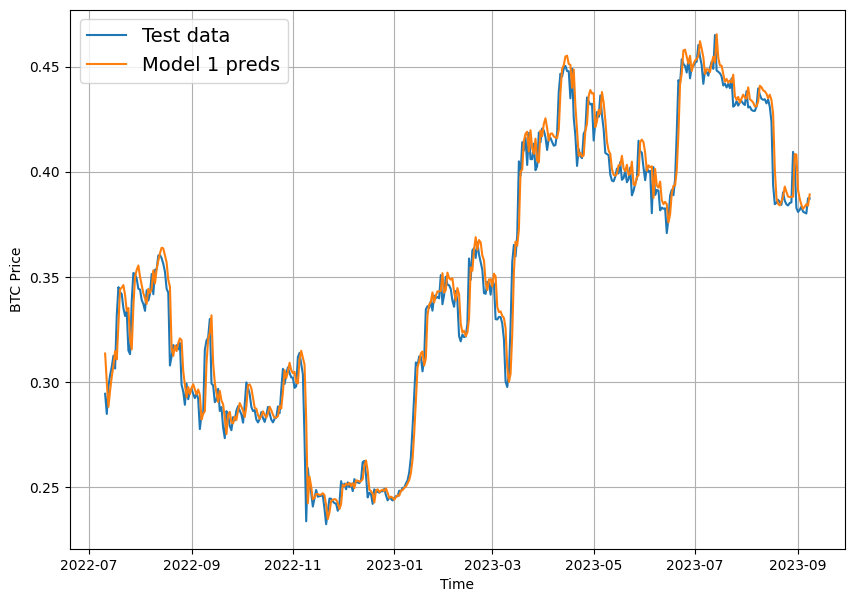

In [86]:
# Let's plot our model 1 predictions
offset= 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:],
                 start=offset,
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 preds")

## Make multivariate time series dataset

In [87]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 #3 jan 2009
block_reward_2 = 25 #8 nov 2012
block_reward_3 = 12.5 #9 jul 2016
block_reward_4 = 6.25 #18 may 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-12-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [88]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [89]:
# Add in block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [102]:
# Initialize the MinMaxScaler
Scaler = MinMaxScaler()

# Assuming you have already defined the 'block_reward' column, you can normalize it as follows:
block_reward = bitcoin_prices_block["block_reward"].values.reshape(-1, 1)  # Reshape for MinMaxScaler
bitcoin_prices_block["block_reward_normalized"] = Scaler.fit_transform(block_reward)

In [101]:
bitcoin_prices_block["Price"] = norm_price
block_reward = bitcoin_prices_block["block_reward"].drop(bitcoin_prices_block.index)
print(block_reward)
bitcoin_prices_block["block_reward"]  = scaler.fit_transform(tf.expand_dims(block_reward, axis=1).numpy())

Series([], Name: block_reward, dtype: object)


ValueError: ignored

In [108]:
bitcoin_prices_block.head()

Price block_reward  block_reward_normalized
Date                                                      
2013-10-01  0.000223           25                      1.0
2013-10-02  0.000250           25                      1.0
2013-10-03  0.000000           25                      1.0
2013-10-04  0.000150           25                      1.0
2013-10-05  0.000189           25                      1.0

In [107]:
bitcoin_prices_block.drop(["block_reward"]).plot();

KeyError: ignored

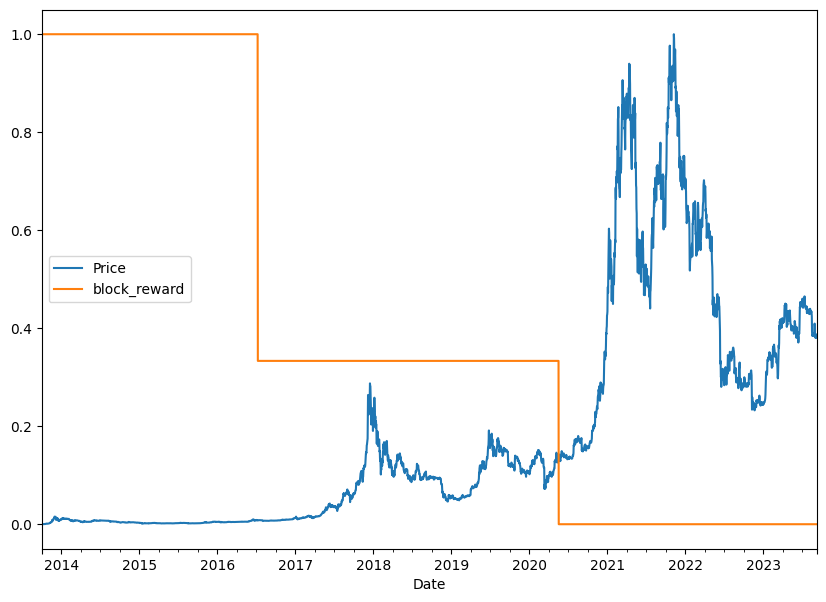

In [ ]:
# Plot the block reward vs price oveer time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                   columns=bitcoin_prices_block.columns,
                                                   index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

### Making a windowed dataset with pandas
Using the pandas.DataFrame.shift()

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()
bitcoin_prices_windowed["block_reward"] = minmax_scale(bitcoin_prices_windowed["block_reward"])
# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window_size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

Price  block_reward   Price+1   Price+2   Price+3   Price+4  \
Date                                                                         
2013-10-01  0.000223           1.0       NaN       NaN       NaN       NaN   
2013-10-02  0.000250           1.0  0.000223       NaN       NaN       NaN   
2013-10-03  0.000000           1.0  0.000250  0.000223       NaN       NaN   
2013-10-04  0.000150           1.0  0.000000  0.000250  0.000223       NaN   
2013-10-05  0.000189           1.0  0.000150  0.000000  0.000250  0.000223   
2013-10-06  0.000179           1.0  0.000189  0.000150  0.000000  0.000250   
2013-10-07  0.000196           1.0  0.000179  0.000189  0.000150  0.000000   
2013-10-08  0.000214           1.0  0.000196  0.000179  0.000189  0.000150   
2013-10-09  0.000229           1.0  0.000214  0.000196  0.000179  0.000189   
2013-10-10  0.000258           1.0  0.000229  0.000214  0.000196  0.000179   

             Price+5   Price+6   Price+7  
Date                                      
2013-10-01       NaN       NaN       NaN  
2013-10-02       NaN       NaN       NaN  
2013-10-03       NaN       NaN       NaN  
2013-10-04       NaN       NaN       NaN  
2013-10-05       NaN       NaN       NaN  
2013-10-06  0.000223       NaN       NaN  
2013-10-07  0.000250  0.000223       NaN  
2013-10-08  0.000000  0.000250  0.000223  
2013-10-09  0.000150  0.000000  0.000250  
2013-10-10  0.000189  0.000150  0.000000

What we've done is created a way to window our dataset
directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X(windows) and y(horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

block_reward   Price+1   Price+2   Price+3   Price+4   Price+5  \
Date                                                                         
2013-10-08           1.0  0.000196  0.000179  0.000189  0.000150  0.000000   
2013-10-09           1.0  0.000214  0.000196  0.000179  0.000189  0.000150   
2013-10-10           1.0  0.000229  0.000214  0.000196  0.000179  0.000189   
2013-10-11           1.0  0.000258  0.000229  0.000214  0.000196  0.000179   
2013-10-12           1.0  0.000247  0.000258  0.000229  0.000214  0.000196   

             Price+6   Price+7  
Date                            
2013-10-08  0.000250  0.000223  
2013-10-09  0.000000  0.000250  
2013-10-10  0.000150  0.000000  
2013-10-11  0.000189  0.000150  
2013-10-12  0.000179  0.000189

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2898, 2898, 725, 725)

## Model 6: Dense(multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name= "model_6_dense_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer="adam")

# fit the model
model_6.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=128,
            verbose=1,
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0595 - val_loss: 0.0789
Epoch 2/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0141 - val_loss: 0.0157
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0169
Epoch 4/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0153
Epoch 5/100
23/23 [==============================] - 0s 18ms/step - loss: 0.0058 - val_loss: 0.0138
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0175
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0181
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0177
Epoch 9/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0053 - val_loss: 0.0127
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0149
Epoc

In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.0120


0.012028069235384464

In [ ]:
# Load in thr best performing model[
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.0107


0.010734985582530499

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

23/23 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.6682105 , 0.6872313 , 0.7048722 , 0.7132498 , 0.69968444,
       0.7068492 , 0.69983655, 0.64744276, 0.59875065, 0.61795235],
      dtype=float32)>

In [ ]:
# Evaluate predictions to get evaluate metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 0.010734985,
 'mape': 2.2180398,
 'mase': 1.0691637,
 'mse': 0.0002807719,
 'rmse': 0.01675625}

### Fomating windows and horizons using `tf.timeseries_dataset_from_array`

In [ ]:
def make_windows_horizon(x, horizon=HORIZON, window_size=WINDOW_SIZE):
  """
  Returns windows and horizons
  """
  labels = x[WINDOW_SIZE:]
  data= x[:]
  windowed_data = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                         targets=labels,
                                                         sequence_length=window_size)
     # Initialize empty lists to collect windows and labels
  windows = []
  all_labels = []

  for data in windowed_data:
        batch_windows, batch_labels = data
        windows.extend(batch_windows.numpy())
        all_labels.extend(batch_labels.numpy())

  # Convert lists to NumPy arrays
  windows = np.array(windows)
  all_labels = np.array(all_labels)

  return windows, all_labels

In [ ]:
full_windows, full_labels= make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels)

(3623, 3623)

In [ ]:
_# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: 123.033
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: 124.049
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: 125.96116


For most of models we used WINDOW_SIZE=7, but is there a better window size?
## Setup a series of experiments to find whether or not there's a better window size.
For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12

In [ ]:
# Modelling experiments in loop
WINDOW_SIZE = 2
HORIZON = 1

# Initialize an empty dictionary to store model results
model_results = {}

for i in range(11):

  # make windows data
  make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)

  # get the windows and labels
  full_windows, full_labels= make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)

  # # View the first 3 windows/labels
  # for j in range(3):
  #   print(f"Window: {full_windows[j]} -> Label: {full_labels[j]}")


  # spliting to train and test sets
  train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

  # create the model
  model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON, activation="linear")
  ],name=f"model_{i}_dense")

  # compile the model
  model.compile(optimizer="adam",
                metrics=["mae","mse"],
                loss="mae")

  print(f"\n Training model: {i} with Window_size: {WINDOW_SIZE} and Horizon: 1")

  # fit the model
  model.fit(train_windows,train_labels,
            epochs=50,
            validation_data=(test_windows,test_labels),
            verbose=0,
            batch_size=128,
            callbacks=[create_model_checkpoint(model.name)])

  print(f"Model {i} trained")

  print(f"Evaluating model...")
  tf.keras.models.load_model(f"model_experiments/model_{i}_dense")
  print(model.evaluate(test_windows, test_labels), "\n")

  print(f"Making predictions with model {i}")
  # Make predictions
  preds = make_preds(model, test_windows)

  # Evaluate predictions
  results_model = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred =preds)
  # Calculate and store model evaluation results in the dictionary
  model_results[f"model_{i}_WS({WINDOW_SIZE})"] = results_model
  print(f"Results model {i}: \n {results_model}")
  print("----------\n")
  WINDOW_SIZE += 1


 Training model: 0 with Window_size: 2 and Horizon: 1
Model 0 trained
Evaluating model...
23/23 [==============================] - 0s 3ms/step - loss: 700.8029 - mae: 700.8029 - mse: 1228817.6250
[700.8028564453125, 700.8028564453125, 1228817.625] 

Making predictions with model 0
23/23 [==============================] - 0s 2ms/step
Results model 0: 
 {'mae': 700.80286, 'mape': 2.1460521, 'mase': 1.0316235, 'mse': 1228817.8, 'rmse': 1108.5205}
----------


 Training model: 1 with Window_size: 3 and Horizon: 1
Model 1 trained
Evaluating model...
23/23 [==============================] - 0s 3ms/step - loss: 684.8154 - mae: 684.8154 - mse: 1179774.3750
[684.8153686523438, 684.8153686523438, 1179774.375] 

Making predictions with model 1
23/23 [==============================] - 0s 1ms/step
Results model 1: 
 {'mae': 684.8155, 'mape': 2.091208, 'mase': 1.0080892, 'mse': 1179774.6, 'rmse': 1086.1743}
----------


 Training model: 2 with Window_size: 4 and Horizon: 1
Model 2 trained
Evaluatin

In [ ]:
# Convert the dictionary to a DataFrame
model_results_df = pd.DataFrame.from_dict(model_results, orient='index')

In [ ]:
model_results_df

mae      mape      mase          mse         rmse
model_0_WS(2)    700.802856  2.146052  1.031623  1228817.750  1108.520508
model_1_WS(3)    684.815491  2.091208  1.008089  1179774.625  1086.174316
model_2_WS(4)    814.956848  2.509330  1.199665  1400485.750  1183.421143
model_3_WS(5)    732.005859  2.255085  1.080743  1271658.750  1127.678467
model_4_WS(6)    730.502930  2.244887  1.078524  1309830.125  1144.478149
model_5_WS(7)    761.588379  2.337323  1.124419  1310362.250  1144.710571
model_6_WS(8)    996.015320  3.111522  1.470529  1821571.000  1349.655884
model_7_WS(9)    740.070923  2.281301  1.092650  1301984.875  1141.045532
model_8_WS(10)   722.365479  2.219613  1.067396  1269739.500  1126.827148
model_9_WS(11)   871.017883  2.721735  1.287050  1615286.750  1270.939331
model_10_WS(12)  900.668518  2.829595  1.330863  1697352.625  1302.824829

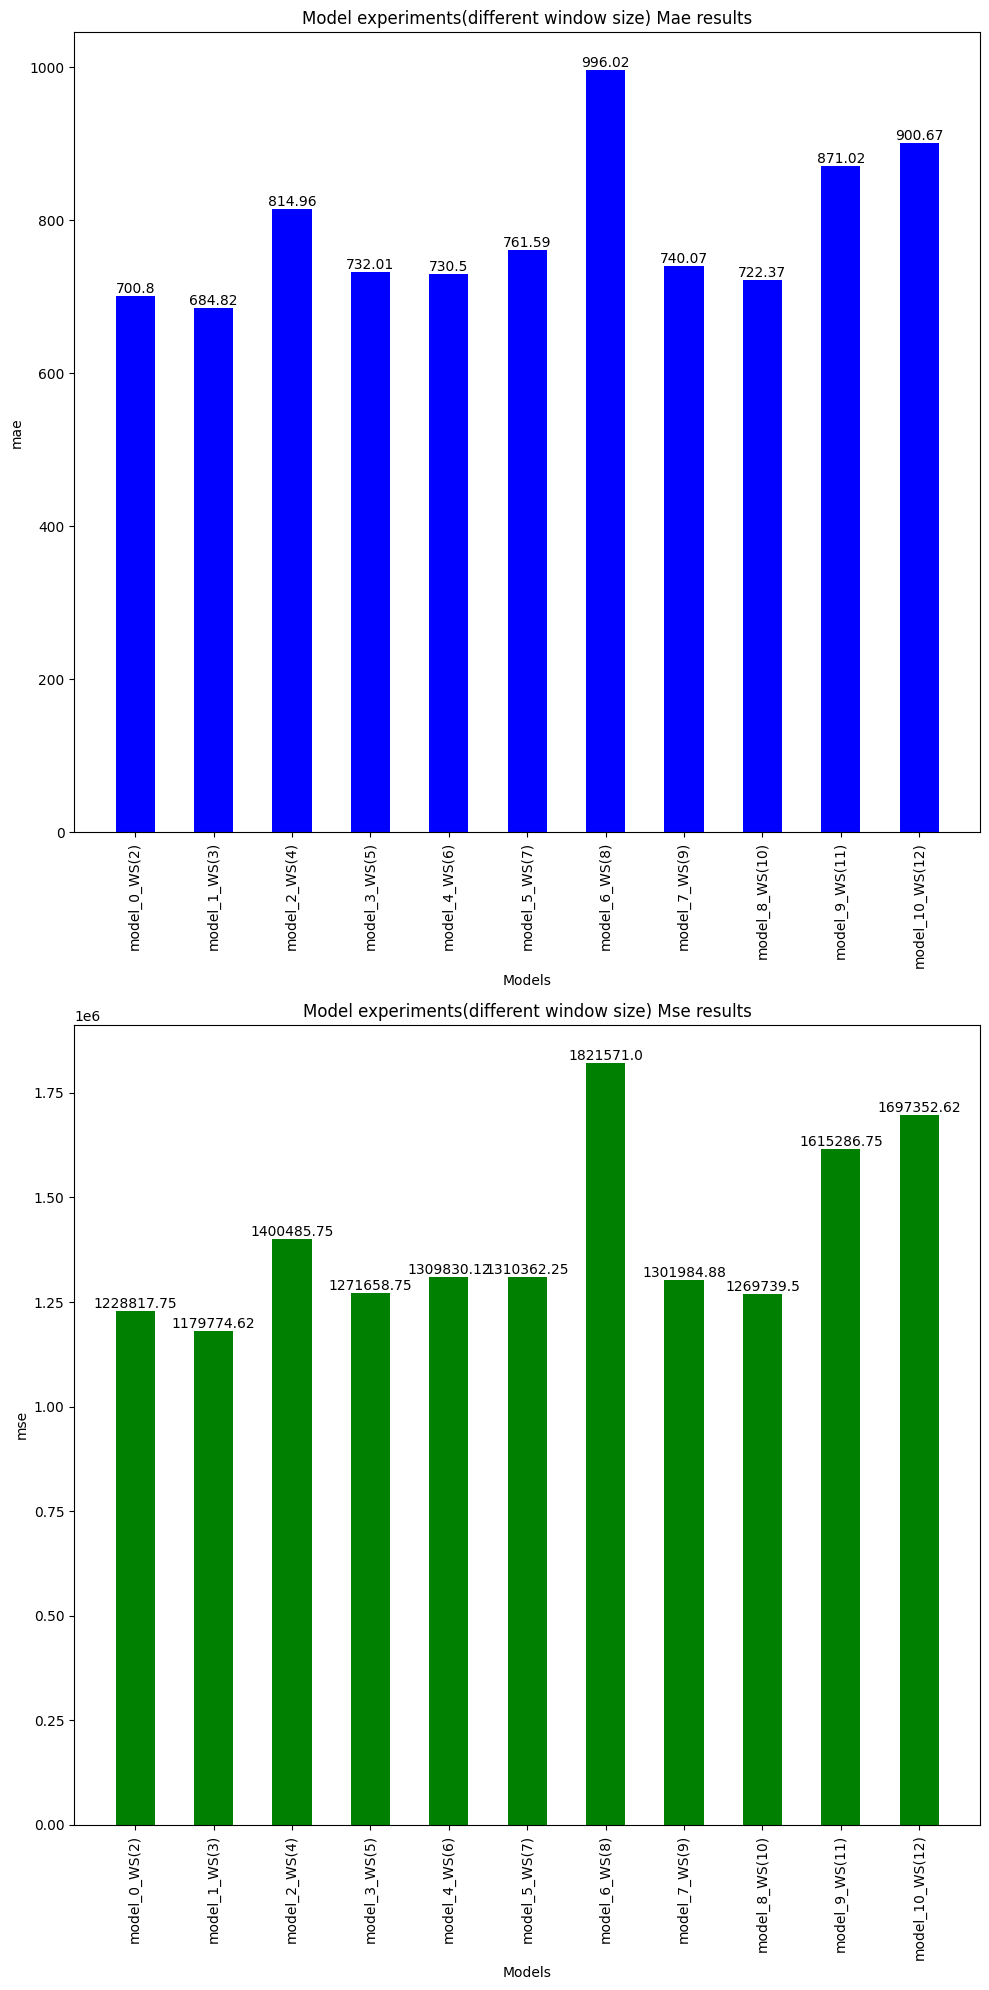

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics and corresponding colors
metrics = ["mae", "mse"]
colors = ["blue", "green", "indigo", "violet"]

# Create a single column of subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(10,20))

# Iterate through metrics
for i, metric in enumerate(metrics):
    ax = axes[i]
    plot_metric = ax.bar(model_results_df.index, model_results_df[metric], color=colors[i], width=0.5)
    ax.set_xlabel("Models")
    ax.set_ylabel(metric)
    ax.set_xticks(model_results_df.index)
    ax.set_xticklabels(model_results_df.index, rotation=90)
    ax.set_title(f"Model experiments(different window size) {metric.capitalize()} results")

    # Annotate the bars with their values
    for bar in plot_metric:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()



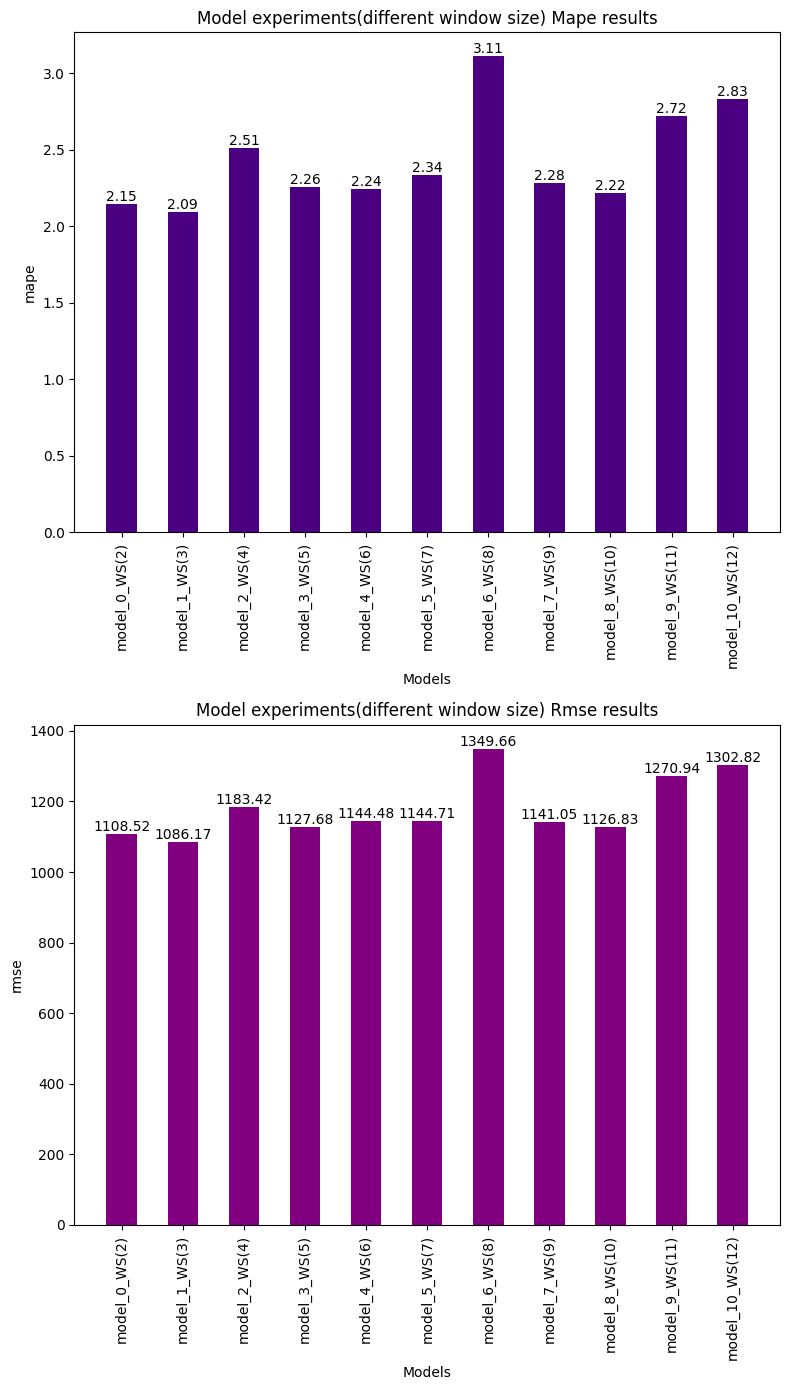

In [ ]:
import matplotlib.pyplot as plt


# Define the metrics and corresponding colors
metrics = ["mape", "rmse"]
colors = ["indigo", "purple"]

# Create a single column of subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8,14))

# Iterate through metrics
for i, metric in enumerate(metrics):
    ax = axes[i]
    plot_metric = ax.bar(model_results_df.index, model_results_df[metric], color=colors[i], width=0.5)
    ax.set_xlabel("Models")
    ax.set_ylabel(metric)
    ax.set_xticks(model_results_df.index)
    ax.set_xticklabels(model_results_df.index, rotation=90)
    ax.set_title(f"Model experiments(different window size) {metric.capitalize()} results")

    # Annotate the bars with their values
    for bar in plot_metric:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()



It's seen that WINDOW_SIZE 3 works best on all evaluation metrics

## Make prediction intervals for future forecasts.
To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 3

### Constructing and fitting and ensemble of models (using different loss functions)

In [ ]:
# Create dataset
# Add windowed columns
bitcoin_prices_ensemble = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_ensemble[f"Price+ {i+1}"] = bitcoin_prices_ensemble["Price"].shift(periods=i+1)
bitcoin_prices_ensemble.dropna().head()

# Make features and labels
X = bitcoin_prices_ensemble.dropna().drop("Price", axis=1)
y = bitcoin_prices_ensemble.dropna()["Price"]

# MAke train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(2901, 2901, 726, 726)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                         train_data=train_dataset,
                         test_data=test_dataset,
                         num_iter=10,
                         num_epochs=1000,
                         loss_fns=["mae","mse" ,"mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE, RMSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae","mse" ,"mape"])
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing : {loss_function} for {num_epochs} epochs")

      # Construct a simple model (similar to model 1)
      model  = tf.keras.Sequential([
        # Initializer dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal" ,activation ="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # compile the model with current loss function
      model.compile(loss=loss_function,
                    optimizer="adam",
                    metrics=["mae", "mse"])

      # fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemle model
ensemble_model = get_ensemble_models(num_iter=5,
                                     num_epochs=1000)

Optimizing model by reducing : mae for 1000 epochs

Epoch 331: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 747: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 847: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing : mse for 1000 epochs

Epoch 175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 275: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mape for 1000 epochs

Epoch 139: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 239: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mae for 1000 epochs

Epoch 685: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing : mse for 1000 epochs

Epoch 322: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 422: ReduceLROnPl

In [ ]:
len(ensemble_model)

15

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds= []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_model,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 40ms/step
CPU times: user 733 ms, sys: 24.7 ms, total: 758 ms
Wall time: 872 ms


<tf.Tensor: shape=(15, 726), dtype=float32, numpy=
array([[46104.92 , 45103.992, 47011.61 , ..., 25706.469, 25677.494,
        26251.104],
       [45973.72 , 45121.945, 46983.477, ..., 25747.541, 25731.371,
        26178.875],
       [46049.113, 44786.68 , 46990.336, ..., 25787.025, 25763.188,
        26239.523],
       ...,
       [46071.65 , 44979.613, 46996.242, ..., 25746.693, 25729.498,
        26225.264],
       [46243.6  , 44925.137, 46582.086, ..., 25666.488, 25643.918,
        26198.668],
       [46042.66 , 44863.41 , 47027.3  , ..., 25715.174, 25672.72 ,
        26174.852]], dtype=float32)>

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)

ensemble_results

{'mae': array([684.594  , 686.46075, 680.0265 , 687.5946 , 693.254  , 678.62384,
        682.4133 , 714.6832 , 689.885  , 703.59576, 694.4177 , 681.6731 ,
        684.33704, 705.173  , 681.84906], dtype=float32),
 'mape': array([2.0857615, 2.092387 , 2.0776503, 2.0980089, 2.1085572, 2.0681093,
        2.0836816, 2.1727548, 2.096127 , 2.1499536, 2.1093643, 2.0780032,
        2.0837455, 2.151717 , 2.075795 ], dtype=float32),
 'mase': 1.0155817,
 'mse': array([1152572.2, 1170777.6, 1139339.9, 1172798.9, 1192887. , 1144754.6,
        1155038.4, 1206887.6, 1150630.9, 1170441.4, 1183521.5, 1136649.4,
        1151495.9, 1183136.6, 1141032.9], dtype=float32),
 'rmse': array([1073.5791, 1082.0248, 1067.3987, 1082.9584, 1092.1936, 1069.9321,
        1074.7272, 1098.5844, 1072.6746, 1081.8694, 1087.8977, 1066.1376,
        1073.0778, 1087.7208, 1068.1914], dtype=float32)}

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([46066.715, 44972.934, 46975.26 , 48193.086, 47796.355, 47187.055,
       48176.61 , 47270.   , 43284.14 , 40973.727], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([46049.113, 44976.727, 46983.477, 48240.65 , 47818.25 , 47171.582,
       48175.383, 47265.73 , 43261.336, 40953.305], dtype=float32)

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 684.35406,
 'mape': 2.0841193,
 'mase': 1.0074099,
 'mse': 1150569.8,
 'rmse': 1072.6461}

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 684.14496,
 'mape': 2.083277,
 'mase': 1.0071021,
 'mse': 1152501.1,
 'rmse': 1073.546}

### Plotting the predictions interval(uncertainity estimates) of ensemble model

So far we've been making point predictions with our model.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussain/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1)

In [ ]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): #1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply ultiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the predictions interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([45850.773, 44730.598, 46621.61 , 47794.914, 47646.16 , 47043.074,
        47948.496, 47040.33 , 42822.47 , 40349.71 ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46282.656, 45215.27 , 47328.914, 48591.258, 47946.55 , 47331.035,
        48404.723, 47499.67 , 43745.812, 41597.742], dtype=float32)>)

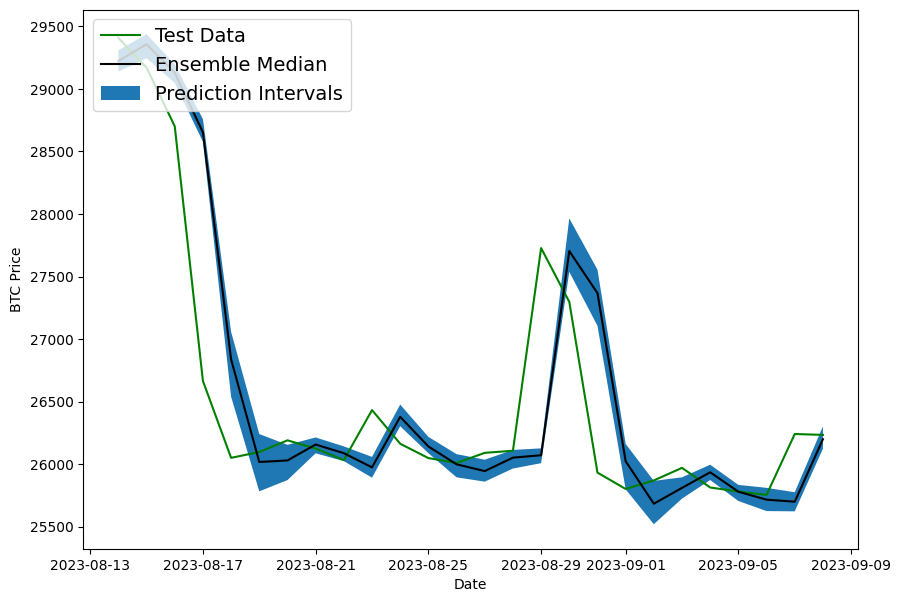

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median =  np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction interval (where the prediction fall between)
offset = 700
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between of matplotlib
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

### Make prediction into future

In [ ]:
# How many timestamps to predict in the future?
INTO_FUTURE = 14

To make predictions into the future we want to function which:

1. Takes as input:
 * a list of values (Bitcoin historical data)
 * a trained model (such as `model_8`)
 * a window into the future to predict(our `INTO_FUTURE` variable)
 * the window size a model was trained on(`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on.
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full on predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after value ends.

  Returns future forecasts as a list of floats.
  """
   # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast  = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # predict on the last window then append it again and again(model will start make forecast on its own forecasts)
    # future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    future_pred= make_ensemble_preds(ensemble_models=ensemble_model,
                                     data=(tf.expand_dims(last_window, axis=0)))

    print(f"Predicting on :\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
bitcoin_prices_windowed.head()

Price  block_reward   Price+1   Price+2   Price+3   Price+4  \
Date                                                                         
2013-10-01  0.000223           1.0       NaN       NaN       NaN       NaN   
2013-10-02  0.000250           1.0  0.000223       NaN       NaN       NaN   
2013-10-03  0.000000           1.0  0.000250  0.000223       NaN       NaN   
2013-10-04  0.000150           1.0  0.000000  0.000250  0.000223       NaN   
2013-10-05  0.000189           1.0  0.000150  0.000000  0.000250  0.000223   

            Price+5  Price+6  Price+7  
Date                                   
2013-10-01      NaN      NaN      NaN  
2013-10-02      NaN      NaN      NaN  
2013-10-03      NaN      NaN      NaN  
2013-10-04      NaN      NaN      NaN  
2013-10-05      NaN      NaN      NaN

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=full_labels,
                                        model=ensemble_model,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 49ms/step
Predicting on :
 [25753.236328 26240.195313 26233.162109] -> Prediction: [25744.166 25785.016 25758.41  25828.238 25754.03  25733.037 25779.664
 25732.209 25666.316 25691.29  25714.334 25694.127 25727.434 25730.516
 25677.973]

1/1 [==============================] - 0s 18ms/step
Predicting on :
 [25727.43359375 25730.515625   25677.97265625] -> Prediction: [25660.93  25710.643 25734.633 25725.049 25626.883 25692.486 25703.457
 25638.99  25688.49  25684.576 25683.947 25668.432 25710.42  25684.4
 25635.809]

1/1 [==============================] - 0s 20ms/step
Predicting on :
 [25710.41992188 25684.40039062 25635.80859375] -> Prediction: [25648.61  25690.115 25721.213 25709.98  25602.922 25674.637 25683.871
 25625.824 25673.818 25675.518 25665.826 25651.248 25693.441 25669.398
 25618.705]

1/1 [==============================] - 0s 17ms/step
Predicting on :
 [25693.44140625 25669.3984375  25618.70507812] -> Prediction: [25631.477 25673.56

In [ ]:
future_forecast

[array([25744.166, 25785.016, 25758.41 , 25828.238, 25754.03 , 25733.037,
        25779.664, 25732.209, 25666.316, 25691.29 , 25714.334, 25694.127,
        25727.434, 25730.516, 25677.973], dtype=float32),
 array([25660.93 , 25710.643, 25734.633, 25725.049, 25626.883, 25692.486,
        25703.457, 25638.99 , 25688.49 , 25684.576, 25683.947, 25668.432,
        25710.42 , 25684.4  , 25635.809], dtype=float32),
 array([25648.61 , 25690.115, 25721.213, 25709.98 , 25602.922, 25674.637,
        25683.871, 25625.824, 25673.818, 25675.518, 25665.826, 25651.248,
        25693.441, 25669.398, 25618.705], dtype=float32),
 array([25631.477, 25673.56 , 25703.797, 25693.006, 25586.736, 25657.736,
        25666.953, 25609.45 , 25656.844, 25658.41 , 25649.197, 25634.389,
        25676.615, 25653.807, 25601.559], dtype=float32),
 array([25614.58 , 25657.014, 25686.658, 25676.197, 25570.473, 25640.97 ,
        25650.156, 25593.123, 25640.059, 25641.57 , 25632.65 , 25617.654,
        25659.9  , 25638.053

In [ ]:
future_forecast_median = np.median(future_forecast, axis=0)
future_forecast_mean= np.mean(future_forecast, axis=0)
future_forecast_median = future_forecast_median[:14]
future_forecast_mean = future_forecast_mean[:14]

In [ ]:
len(future_forecast_median), len(future_forecast_mean)

(14, 14)

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") #return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2023-09-08 00:00:00')

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)

next_time_steps

array(['2023-09-09', '2023-09-10', '2023-09-11', '2023-09-12',
       '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-16',
       '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20',
       '2023-09-21', '2023-09-22'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast_median = np.insert(future_forecast_median, 0, prices[-1])
future_forecast_mean = np.insert(future_forecast_mean, 0, prices[-1])
len(next_time_steps), len(future_forecast_median), len(future_forecast_mean)

(15, 15, 15)

In [ ]:
next_time_steps, future_forecast_median

(array(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
        '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
        '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
        '2023-09-20', '2023-09-21', '2023-09-22'], dtype='datetime64[D]'),
 array([26233.162, 25572.904, 25615.87 , 25644.57 , 25634.613, 25529.803,
        25599.465, 25608.617, 25552.348, 25598.504, 25599.955, 25591.486,
        25576.227, 25618.492, 25598.14 ], dtype=float32))

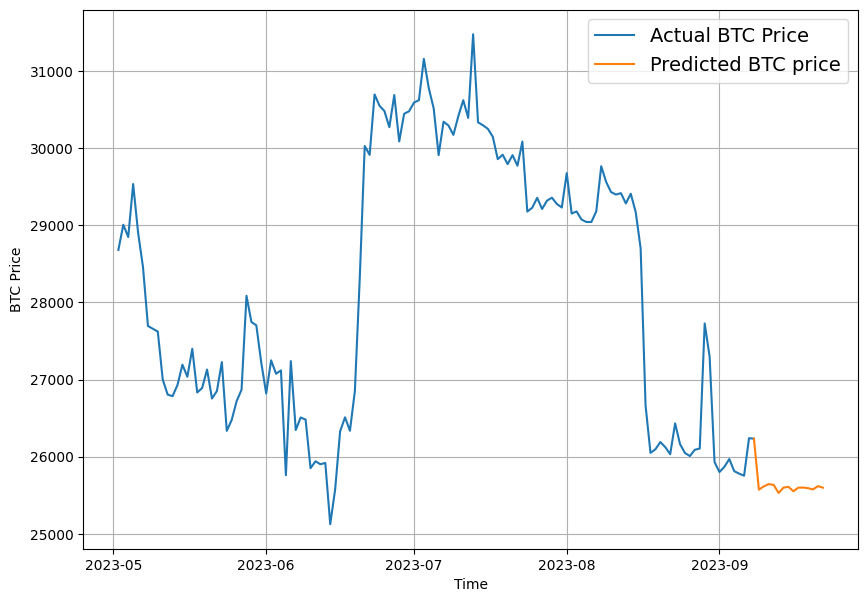

In [ ]:
# Plot future prices prediction of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=3500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast_median, format="-", label="Predicted BTC price")

plt.show()

## Train models for future forecast
Training 2 simple models on full data and making future forecast from it.  

`model_0` : makes future predictions without retraining on predictions.  
`model_1` : makes future predictions with retraining on Predictions.

Plot both model's predictions

In [ ]:
WINDOW_SIZE = 3
HORIZON = 1

### Get all the data

In [ ]:
full_windows, full_labels= make_windows_horizon(x=prices, horizon=HORIZON, window_size=WINDOW_SIZE)

In [ ]:
# Train model on entire data to make predicitons for the next day
X_all = full_windows
# Get labels
y_all = full_labels

len(X_all), len(y_all)

(3627, 3627)

In [ ]:
X_all[:5], y_all[:5]

(array([[123.65499, 125.455  , 108.58483],
        [125.455  , 108.58483, 118.67466],
        [108.58483, 118.67466, 121.33866],
        [118.67466, 121.33866, 120.65533],
        [121.33866, 120.65533, 121.795  ]]),
 array([118.67466, 121.33866, 120.65533, 121.795  , 123.033  ]))

In [ ]:
# Turn data into efficent running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Model 0: Training

In [ ]:
model_0 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile the model
model_0.compile(loss="mae",
                optimizer="adam")

# Fit the model on all of the data to make future forecasts
model_0.fit(dataset_all,
            epochs=100,
            verbose=0)

In [ ]:
model_1 = tf.keras.models.clone_model(model_0)

model_1.compile(loss="mae",
                optimizer="adam")

# Fit the model on all of the data to make future forecasts
model_1.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions in future

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after value ends.

  Returns future forecasts as a list of floats.
  """
   # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast  = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # predict on the last window then append it again and again(model will start make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))

    print(f"Predicting on :\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
# How many timesteps to predict in the future?
INTO_FUTURE = 14

future_forecast = make_future_forecasts(values=y_all,
                      model=model_0,
                      into_future=INTO_FUTURE,
                      window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 49ms/step
Predicting on :
 [25753.236328 26240.195313 26233.162109] -> Prediction: 26294.015625

1/1 [==============================] - 0s 20ms/step
Predicting on :
 [26240.195313 26233.162109 26294.015625] -> Prediction: 26377.609375

1/1 [==============================] - 0s 20ms/step
Predicting on :
 [26233.162109 26294.015625 26377.609375] -> Prediction: 26449.4609375

1/1 [==============================] - 0s 19ms/step
Predicting on :
 [26294.015625  26377.609375  26449.4609375] -> Prediction: 26522.52734375

1/1 [==============================] - 0s 18ms/step
Predicting on :
 [26377.609375   26449.4609375  26522.52734375] -> Prediction: 26596.572265625

1/1 [==============================] - 0s 20ms/step
Predicting on :
 [26449.4609375  26522.52734375 26596.57226562] -> Prediction: 26670.544921875

1/1 [==============================] - 0s 19ms/step
Predicting on :
 [26522.52734375 26596.57226562 26670.54492188] -> Prediction: 26744.72265

Make future predictions with retraining on predictions

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts_retrained(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after value ends.

  Returns future forecasts as a list of floats.
  """
   # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast  = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # predict on the last window then append it again and again(model will start make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))

    print(f"Predicting on :\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

     # Retrain the model
    model.fit(x=tf.expand_dims(last_window, axis=0),
              y=tf.expand_dims((tf.squeeze(future_pred)), axis=0),
              epochs=10,
              verbose=0)

    print(f"Model retrained on Predictions {_}")
  return future_forecast

In [ ]:
# Future forecast retrained
future_forecast_retrained = make_future_forecasts_retrained(values=y_all,
                      model=model_1,
                      into_future=INTO_FUTURE,
                      window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 50ms/step
Predicting on :
 [25753.236328 26240.195313 26233.162109] -> Prediction: 26319.6015625

Model retrained on Predictions 0
1/1 [==============================] - 0s 17ms/step
Predicting on :
 [26240.195313  26233.162109  26319.6015625] -> Prediction: 26421.8125

Model retrained on Predictions 1
1/1 [==============================] - 0s 17ms/step
Predicting on :
 [26233.162109  26319.6015625 26421.8125   ] -> Prediction: 26749.181640625

Model retrained on Predictions 2
1/1 [==============================] - 0s 17ms/step
Predicting on :
 [26319.6015625  26421.8125     26749.18164062] -> Prediction: 27225.658203125

Model retrained on Predictions 3
1/1 [==============================] - 0s 17ms/step
Predicting on :
 [26421.8125     26749.18164062 27225.65820312] -> Prediction: 27984.43359375

Model retrained on Predictions 4
1/1 [==============================] - 0s 18ms/step
Predicting on :
 [26749.18164062 27225.65820312 27984.43359375]

In [ ]:
future_forecast, future_forecast_retrained

([26276.0,
  26402.725,
  26409.404,
  25894.53,
  26101.621,
  26305.125,
  26176.707,
  26146.338,
  26028.299,
  26240.248,
  26464.953,
  26174.773,
  26306.395,
  26444.639],
 [26319.602,
  26421.812,
  26749.182,
  27225.658,
  27984.434,
  27969.756,
  27380.041,
  27773.654,
  27595.377,
  27844.436,
  27542.377,
  27631.113,
  27672.28,
  27666.041])

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
# next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
future_forecast_retrained = np.insert(future_forecast_retrained, 0, prices[-1])
len(next_time_steps), len(future_forecast), len(future_forecast_retrained)

(15, 15, 15)

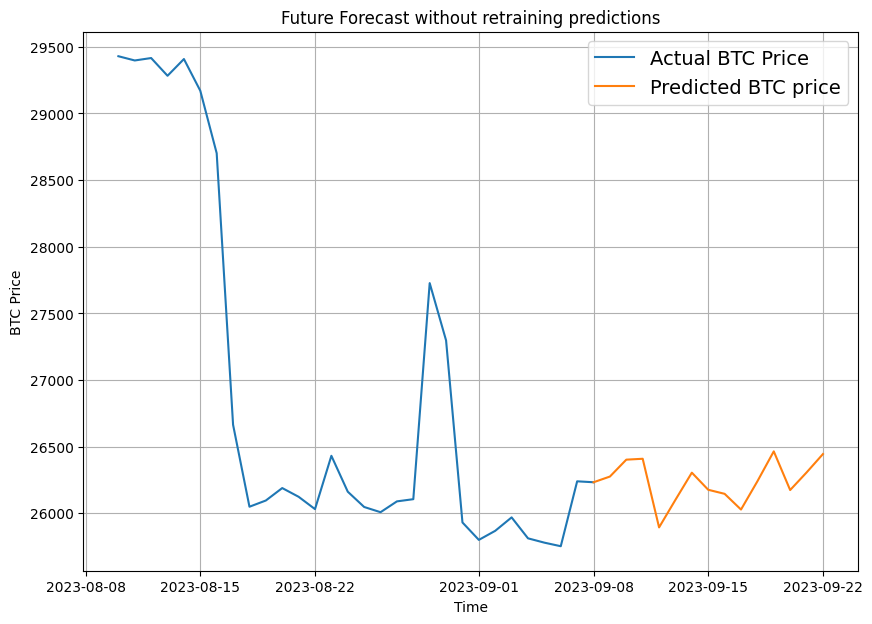

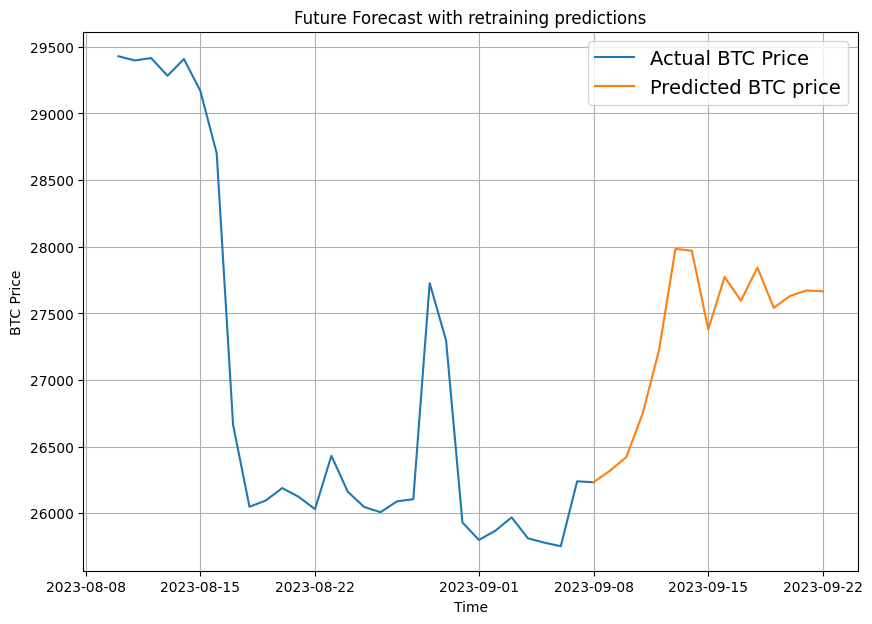

In [ ]:
# Plot future prices prediction of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=3600, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC price")
plt.title("Future Forecast without retraining predictions")

plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=3600, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast_retrained, format="-", label="Predicted BTC price")
plt.title("Future Forecast with retraining predictions")

plt.show()


In [ ]:
pip install greykite

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22.5/22.5 MB 2.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 499.9/499.9 kB 43.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.4/1.4 MB 80.3 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 102.4/102.4 kB 4.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existi

In [ ]:
data = {
    "Date": df.index,
    "Price": df["Price"]
}

df = pd.DataFrame(data)

In [ ]:
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum

# Defines inputs
df = df  # Input time series (pandas.DataFrame)
config = ForecastConfig(
     metadata_param=MetadataParam(time_col="Date", value_col="Price"),  # Column names in `df`
     model_template=ModelTemplateEnum.AUTO.name,  # AUTO model configuration
     forecast_horizon=7,   # Forecasts 24 steps ahead
     coverage=0.95,         # 95% prediction intervals
 )

# Creates forecasts
forecaster = Forecaster()
result = forecaster.run_forecast_config(df=df, config=config)

# Accesses results
result.forecast     # Forecast with metrics, diagnostics
result.backtest     # Backtest with metrics, diagnostics
result.grid_search  # Time series CV result
result.model        # Trained model
result.timeseries   # Processed time series with plotting functions

/usr/local/lib/python3.10/dist-packages/greykite/common/time_properties.py:418: UserWarning: `train_end_date` is not provided, or Price column of the provided time series contains null values at the end, or the input `train_end_date` is beyond the last timestamp available. Setting `train_end_date` to the last timestamp with a non-null value (2023-09-08 00:00:00).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/greykite/common/time_properties.py:418: UserWarning: `train_end_date` is not provided, or Price column of the provided time series contains null values at the end, or the input `train_end_date` is beyond the last timestamp available. Setting `train_end_date` to the last timestamp with a non-null value (2023-09-08 00:00:00).
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:279: UserWarning: Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error 0.01966411858327835 than tolerance 1e-08. Falling back to `h_mat` for more accurate variance estimation.
  warnings.warn(f"Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error "
/usr/local/lib/python3.10/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:279: UserWarning: Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error 0.2573181936385682 than tolerance 1e-08. Falling back to `h_mat` for more accurate variance estimation.
  warnings.warn(f"Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error "
/usr/local/lib/python3.10/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:279: UserWarning: Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt 